# Supervised ML on the UCI Mammographic Mass Data Set

Source: http://archive.ics.uci.edu/ml/datasets/mammographic+mass

Dataset Attributes: 

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal, goal field!)

In [78]:
#inital imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd
import pandas as pd
import io
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#suppress warning 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [79]:
#import data
columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data",
                 names= columns)

# Exploratory Data Analysis 

In [80]:
#take a look at the dataset
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [81]:
#change to numeric type columns (missing values replaced with N/A)
cols= df.columns
df= df[cols].apply(pd.to_numeric, errors='coerce')

In [82]:
#descriptive statistics 
df.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [83]:
# Function to find how many missing values in each column 
def check_missing_values(df): 
    cols = df.columns
    for col in cols:
        print (col, df[df[col].isnull()].shape)

check_missing_values(df)

BI-RADS (2, 6)
Age (5, 6)
Shape (31, 6)
Margin (48, 6)
Density (76, 6)
Severity (0, 6)


In [84]:
#check where are the missing fields (e.g. if correlation from same individuals)
df.loc[(df['BI-RADS'].isnull()) | (df['Age'].isnull()) | (df['Shape'].isnull()) |
              (df['Margin'].isnull()) | (df['Density'].isnull())]

,BI-RADS,Age,Shape,Margin,Density,Severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


### Impute missing values 

In [85]:
#drop BI-RADS as this is not a predicitive feature 
df= df.drop('BI-RADS', axis=1)

In [86]:
#Age column= continous integer 
#function to replace null value with mean of its corresponding class

def impute_av_int(df, col): 
    no_null_df = df.loc[df[col].notnull(), [col, 'Severity']]
    mean0 = no_null_df.groupby('Severity').mean().iloc[0,0] 
    mean1 = no_null_df.groupby('Severity').mean().iloc[1,0] 
    df.loc[(df[col].isnull()) & (df['Severity']==0), col] = mean0
    df.loc[(df[col].isnull()) & (df['Severity']==1), col] = mean1
    
for col in ['Age']:
    impute_av_int(df, col) 

In [87]:
#density= ordinal data 
#function to replace null value by most frequently chosen category/mode of class

def impute_category(df, col):
    no_null_df = df.loc[df[col].notnull(), [col, 'Severity']]
    most_frequent_category_0 = no_null_df.loc[df['Severity']== 0].mode().iloc[0,0] 
    most_frequent_category_1 = no_null_df.loc[df['Severity']== 1].mode().iloc[0,0] 
    df.loc[(df[col].isnull()) & (df['Severity']==0), col] = most_frequent_category_0
    df.loc[(df[col].isnull()) & (df['Severity']==1), col] = most_frequent_category_1

for col in ['Density']:
    impute_category(df, col)

In [88]:
#Margain and shape columns= nominal data 
#function to create new category for missing values in nominal column 
#this category is 6=unknown for Margain and shape 

def create_category(df,col):
     df[col] = np.where(df[col].isnull(),6.0,df[col])
        
for cols in ['Shape', 'Margin']:
    create_category(df,cols)

In [89]:
# check missing values are filled in 
check_missing_values(df)

Age (0, 5)
Shape (0, 5)
Margin (0, 5)
Density (0, 5)
Severity (0, 5)


### Outliers

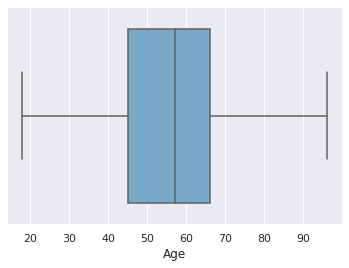

In [90]:
#confirm this with a boxplot (to see outliers based on Interquartile range) 
#outliers would show as below the lower whisker or above the upper whisker.  
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.boxplot(x=df["Age"], palette= 'Blues') 
plt.show()

### Data Visualization 

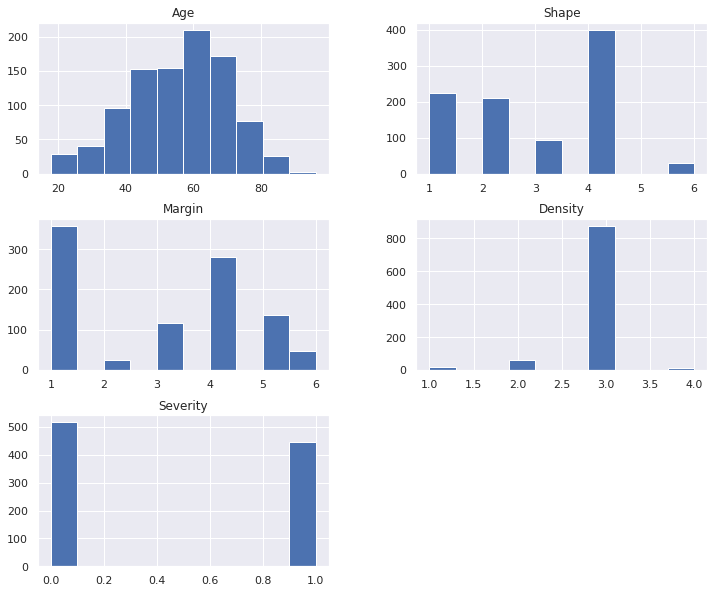

In [91]:
#histograms with frequency distribution of attributes and class
df.hist(figsize=(12,10))  
plt.show()

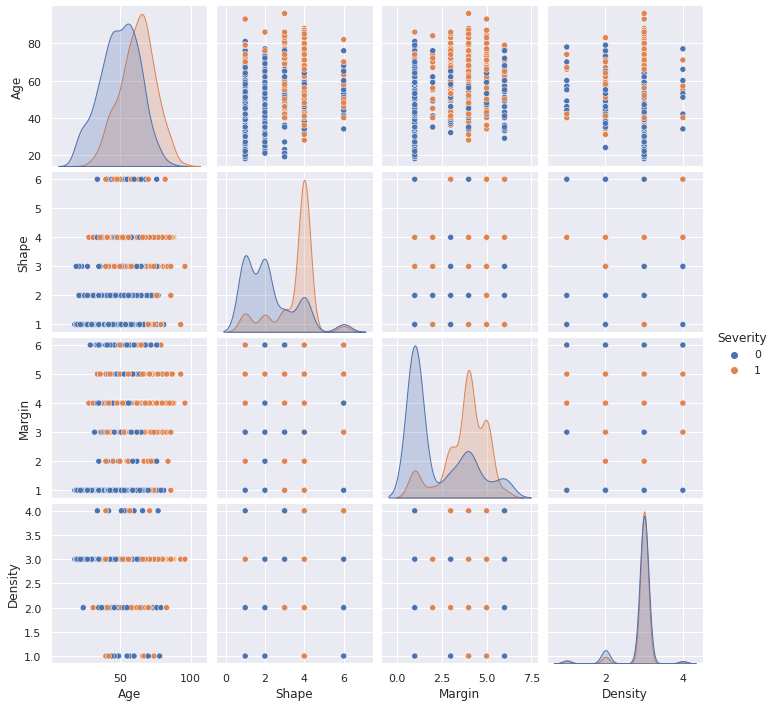

In [92]:
#view the density curves per varaible with sns pairplot
sns.pairplot(df, hue= 'Severity')
plt.show()

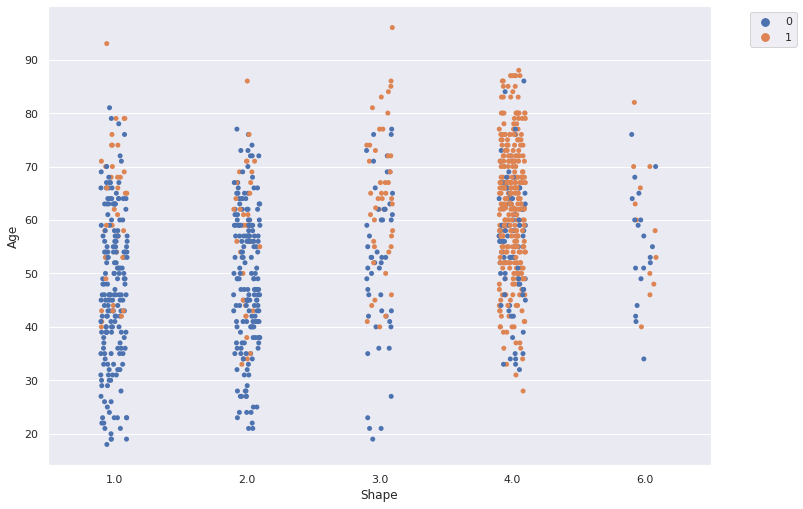

<Figure size 432x288 with 0 Axes>

In [93]:
#make a categorical plot to observe class distrbution across shape 
sns.catplot(y="Age", x="Shape", kind= "strip", data= df, hue= "Severity", height=7,  aspect=11.7/8.27, legend= False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

plt.savefig('....png')

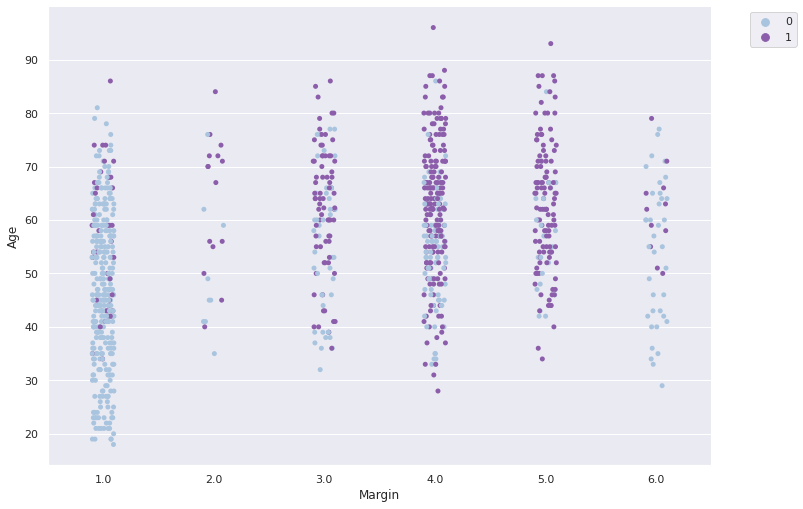

In [94]:
#make a categorical plot to observe class distrbution across margin 
sns.catplot(y="Age", x="Margin", kind= "strip", data= df, hue= "Severity", height=7,  aspect=11.7/8.27, legend= False, palette= "BuPu")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

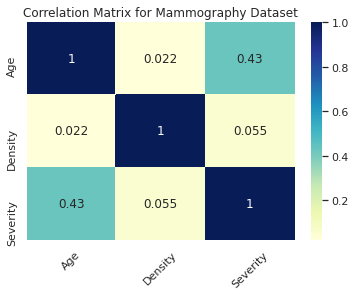

In [95]:
# Take a look a the correlation between pairs of variables
corr = df[["Age", "Density", "Severity"]].corr()
ax = sns.heatmap(corr, annot = True, cmap= "YlGnBu")

plt.setp(ax.axes.get_xticklabels(), rotation=45)
plt.rcParams['figure.figsize']=(12,10)
plt.title('Correlation Matrix for Mammography Dataset')
plt.show()

Density does not appear to be a very predictive attribute for severity, but as there are so few attributes in the dataset I will leave this in for the time being

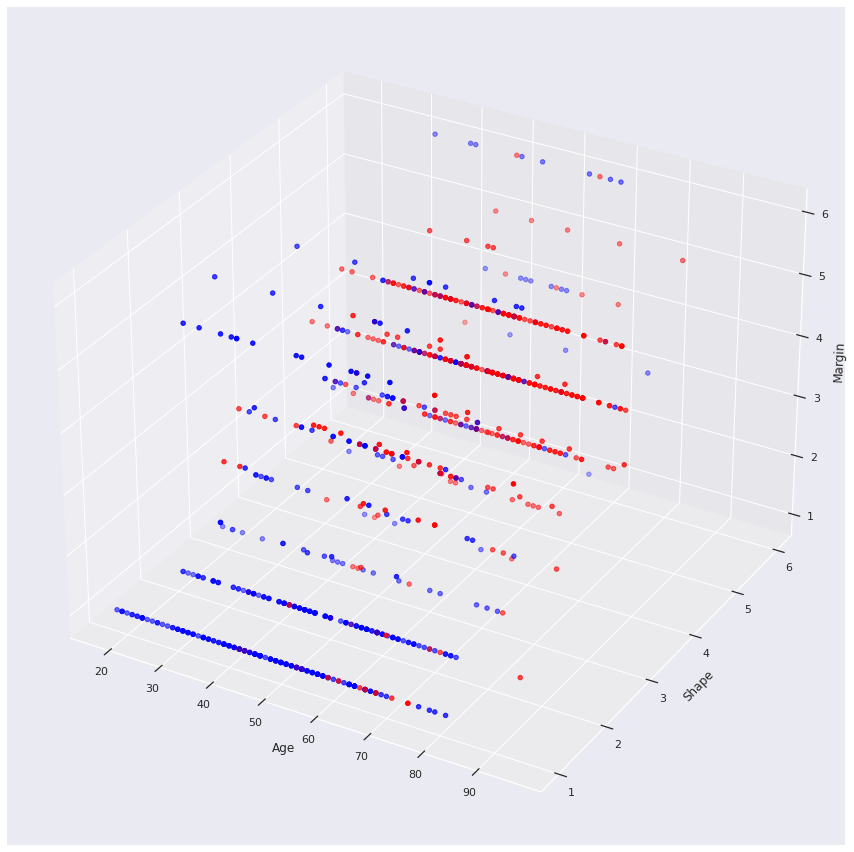

In [96]:
#Explore 3D plot to visualise potential decision boundary 
from matplotlib.ticker import MaxNLocator

feature1 = df['Age'].values
feature2 = df['Shape'].values 
feature3 = df['Margin'].values

df['Severity']=df['Severity'].astype('str')

c = df['Severity'].values
df['Severity']=df['Severity'].astype('int')
c[c=='0'] = 'blue' #benign
c[c=='1'] = 'red' #malignant

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, feature3, c=c)
ax.set_xlabel('Age')
ax.set_ylabel("Shape")
ax.set_zlabel('Margin')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.zaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# Data Preprocessing

In [97]:
#categorical feature types need to be converted to objectice data types 

cat_features = ['Shape','Margin']

class_name= 'Severity'

df[cat_features] = df[cat_features].astype(object)

#transform categorical vars into binary features 
data_one_hot = pd.get_dummies(df)

In [98]:
#check out the features 
features_one_hot = list(data_one_hot.columns)
features_one_hot.remove(class_name)
features_one_hot

['Age',
 'Density',
 'Shape_1.0',
 'Shape_2.0',
 'Shape_3.0',
 'Shape_4.0',
 'Shape_6.0',
 'Margin_1.0',
 'Margin_2.0',
 'Margin_3.0',
 'Margin_4.0',
 'Margin_5.0',
 'Margin_6.0']

In [99]:
#move class column to the first one in the df 
first_col = data_one_hot.pop("Severity")
data_one_hot.insert(0, "Severity", first_col)

In [100]:
#check out data now 
data_one_hot.head()

,Severity,Age,Density,Shape_1.0,Shape_2.0,Shape_3.0,Shape_4.0,Shape_6.0,Margin_1.0,Margin_2.0,Margin_3.0,Margin_4.0,Margin_5.0,Margin_6.0
0,1,67.0,3.0,0,0,1,0,0,0,0,0,0,1,0
1,1,43.0,3.0,1,0,0,0,0,1,0,0,0,0,0
2,1,58.0,3.0,0,0,0,1,0,0,0,0,0,1,0
3,0,28.0,3.0,1,0,0,0,0,1,0,0,0,0,0
4,1,74.0,3.0,1,0,0,0,0,0,0,0,0,1,0


In [101]:
#split variables (X) and class (y)
array = data_one_hot.values
X = array[:,1:]
y = np.array(array[:,:1])
y= y.reshape(-1)

In [102]:
#check shape of X and y
print(X.shape)
print(y.shape)

(961, 13)
(961,)


In [103]:
#check balance of classes
ben_data = df[df['Severity'] == 0]
mal_data = df[df['Severity'] == 1]
print ("Number of benign mammographics masses:", len(ben_data)) 
print ("Fraction of benign mammographics masses:", round(len(ben_data) / float(len(df["Severity"])), 2))  
print ("Number of benign mammographics masses:", len(mal_data)) 
print ("Fraction of malign mammographic masses:", round(len(mal_data) / float(len(df["Severity"])), 2))
print ("Total masses:", len(df["Severity"]))

Number of benign mammographics masses: 516
Fraction of benign mammographics masses: 0.54
Number of benign mammographics masses: 445
Fraction of malign mammographic masses: 0.46
Total masses: 961


NOTE: There is a small class imbalance in this dataset, so I will use F1-score for model evaluation (where the positive label is 10. 

In [104]:
# Train/test split of our data
from sklearn.model_selection import train_test_split

#30% as test and 70% for taining 
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=101, stratify= y)

print ("number of instances for training: ", len(y_train))
print ("number of instances for test: ", len(y_test))

number of instances for training:  672
number of instances for test:  289


NOTE: Decison trees and Adaboost do note require feature scaling so I will not scale here but if want to apply other alogirthms need to use StandardScaler()

# 1. Decision Tree Classifier 

Details here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

N.B. Please see report for psuedocode

In [105]:
#import the model 
from sklearn.tree import DecisionTreeClassifier

In [106]:
# Create a DecisionTreeClassifier and fit it to the training data
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=2, criterion='gini', splitter = "best", random_state=101)

# Train the classifier on the training set
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=101)

In [107]:
#check model parameters 
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 101,
 'splitter': 'best'}

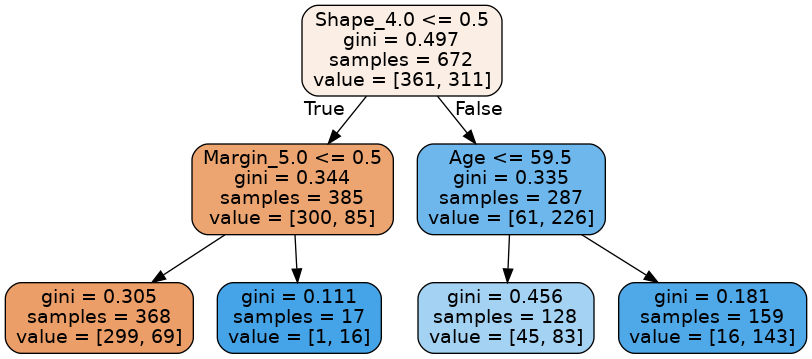

In [108]:
# Visualise the resulting decision tree
from IPython.display import Image
from six import StringIO
from sklearn import tree
from pydotplus import graph_from_dot_data

feature_names= list(data_one_hot.iloc[:, 1:].columns)

dot_data = StringIO() 
tree.export_graphviz(dtree, out_file=dot_data, feature_names=feature_names, filled=True,rounded=True)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

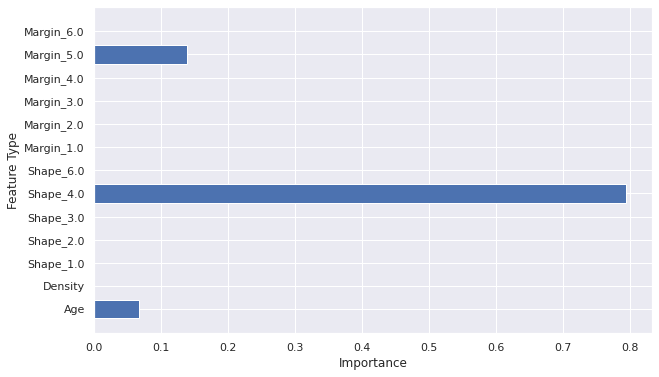

In [109]:
#plot feature importances 
feature_imps= dtree.feature_importances_
plt.figure(figsize= (10,6))
plt.barh(feature_names, feature_imps)
plt.xlabel('Importance')
plt.ylabel('Feature Type')
plt.show()

### Performance Metrics

In [110]:
# import the performance metrics 
from sklearn.metrics import f1_score

#Make predicitons on the training and test sets 
dtree_predict_train= dtree.predict(X_train)
dtree_predict_test = dtree.predict(X_test) 

# Performance 
print(f"F1 on training set: {(round(f1_score(y_train, dtree_predict_train), 3))}") 
print(f"F1 on test set: {(round(f1_score(y_test, dtree_predict_test), 3))}")

F1 on training set: 0.787
F1 on test set: 0.743


In [111]:
#Use K-Fold cross validation instead of train-test split to get a more robust measure of f1, K=10
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score

#weight the average by the number of instances in each class, accounting for label imbalance 
scorer = make_scorer(f1_score, pos_label= 1) 

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=101)
dtree_scores = cross_val_score(dtree, X_train, y_train, scoring= scorer, cv=cv)

print('K-fold cross validation score: %.3f +/- %.3f' % (np.mean(dtree_scores), np.std(dtree_scores)))

K-fold cross validation score: 0.760 +/- 0.055


In [112]:
#take a look at classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, dtree_predict_test))

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       155
         1.0       0.79      0.70      0.74       134

    accuracy                           0.78       289
   macro avg       0.78      0.77      0.77       289
weighted avg       0.78      0.78      0.77       289



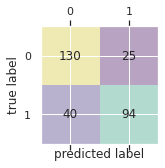

In [113]:
#imports
from sklearn.metrics import confusion_matrix

#make a plot of the confusion matrix
#please note top left= TNs, top right= FPs, bottom left= FNs, bottom right= TPs 
dtree_cfmat = confusion_matrix(y_true=y_test, y_pred=dtree_predict_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(dtree_cfmat, cmap=plt.cm.viridis, alpha=0.3)
for i in range(dtree_cfmat.shape[0]):
    for j in range(dtree_cfmat.shape[1]):
        ax.text(x=j, y=i, s=dtree_cfmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

In [114]:
#function to plot the learning curve (understand number of samples needed to reach optimum validation score)
#sensitivity analysis 
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, train_sizes, cv): 

    train_sizes, train_scores, test_scores =\
                learning_curve(estimator= model, 
                X=X, 
                y=y, 
                train_sizes=train_sizes, 
                cv=cv,
                scoring= scorer,
                n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training')

    plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation')

    plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

    plt.grid()
    plt.title(f'Learning curve for {model}')
    plt.xlabel('Number of training samples')
    plt.ylabel('Cross Validation Score (f1)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

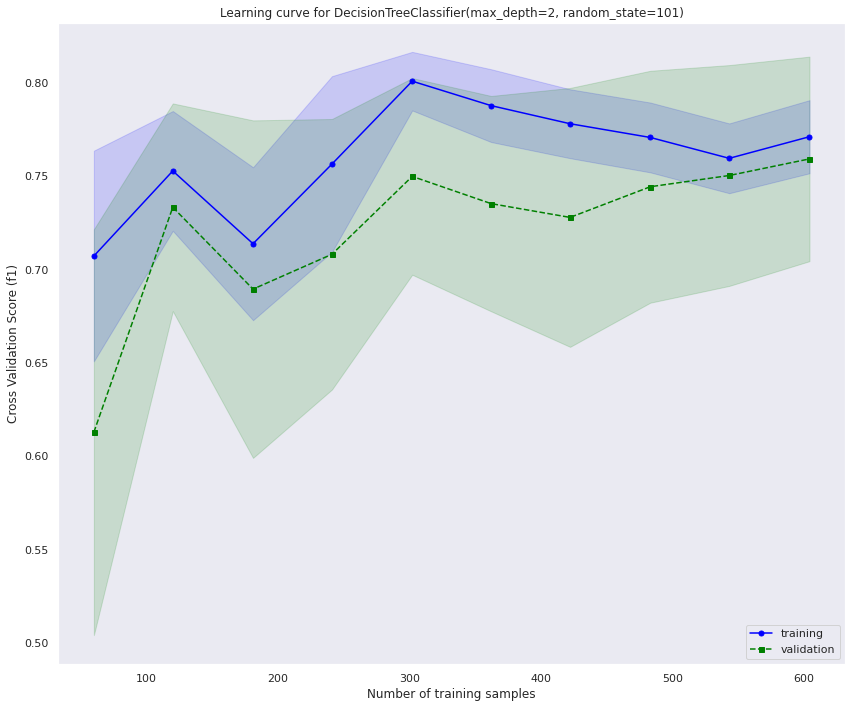

In [115]:
#plot the learning curve
#to see bias variance trade off 
train_sizes=np.linspace(0.1, 1.0, 10)
plot_learning_curve(dtree, X_train, y_train, train_sizes, cv)

### Hyperparameter Tuning 

In [116]:
#function to plot validation curve 
from sklearn.model_selection import validation_curve
import psutil

def plot_val_curve(model, X, y, param_name, cv, param_range, scoring): 
    
    train_scores, test_scores = validation_curve(
    model, X=X, y=y, param_name=param_name, cv=cv, 
    param_range=param_range,n_jobs=psutil.cpu_count(),scoring=scoring)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training')

    plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

    plt.plot(param_range, test_mean, 
                 color='green', linestyle='--', 
                 marker='s', markersize=5, 
                 label='validation')

    plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

    plt.grid()
    plt.legend(loc='upper left')
    plt.ylabel(f'{scoring}')
    plt.title(f"Validation Curve with {model}")
    plt.xlabel(f"{param_name}")
    plt.tight_layout()
    plt.show()

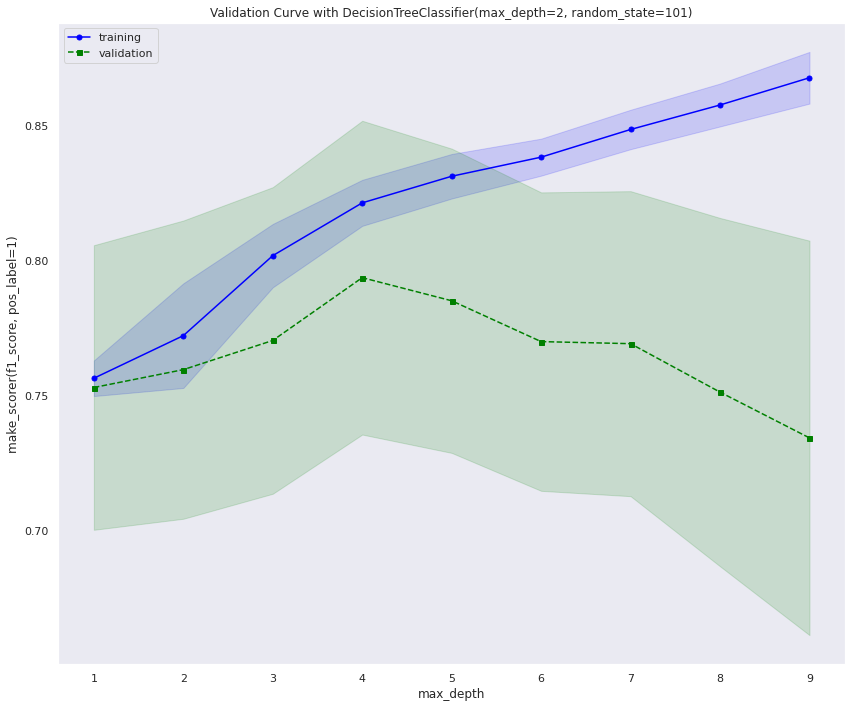

In [117]:
#plot the validation curve for dtree
depth_param_range = np.arange(1, 10, 1)
plot_val_curve(dtree, X_train, y_train, "max_depth", cv, depth_param_range, scorer)

This suggests there is a high chance the model has overfitted to the training data after 4 layers. Before 4 layers the accuracy on the validation set tracks nicely with that on the training set, seeing an improvement up to 4 layers before accuracy declines on the validation set. 

In [118]:
#grid search with different max depth and split criteria to find the optimum hyperparameters 
from sklearn.model_selection import GridSearchCV

param_dict= {'criterion':['gini', 'entropy'],'max_depth': np.arange(1, 10, 1)}

dtree_gs = GridSearchCV(DecisionTreeClassifier(random_state=101), scoring= scorer, param_grid=param_dict, cv=cv)
dtree_gs.fit(X_train, y_train)
print(round(dtree_gs.best_score_, 3))
print(dtree_gs.best_params_)

0.794
{'criterion': 'gini', 'max_depth': 4}


In [119]:
#use best hyperparameters from grid search as final model 
final_dtree = dtree_gs.best_estimator_
final_dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=101)

In [120]:
#kfold cross validation f1 score 
final_dtree_scores = cross_val_score(final_dtree, X_train, y_train, scoring= scorer, cv=cv, n_jobs=-1)

print('Final Kfold cross val f1: %.3f (%.3f)' % (np.mean(final_dtree_scores), np.std(final_dtree_scores)))

Final Kfold cross val f1: 0.794 (0.058)


In [121]:
final_dtree_predict_train= final_dtree.predict(X_train)
final_dtree_predict_test = final_dtree.predict(X_test) 
final_dtree_train = f1_score(y_train, final_dtree_predict_train) 
final_dtree_test = f1_score(y_test, final_dtree_predict_test) 
print('Dtree train/test f1: %.3f/%.3f'
      % (final_dtree_train, final_dtree_test))

Dtree train/test f1: 0.817/0.767


In [122]:
#Check out peformance classification report and confusion matrix 
print(confusion_matrix(y_test, final_dtree_predict_test))
print(classification_report(y_test, final_dtree_predict_test))

[[133  22]
 [ 37  97]]
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82       155
         1.0       0.82      0.72      0.77       134

    accuracy                           0.80       289
   macro avg       0.80      0.79      0.79       289
weighted avg       0.80      0.80      0.79       289



In [123]:
print(confusion_matrix(y_test, dtree_predict_test))
print(classification_report(y_test, dtree_predict_test))

[[130  25]
 [ 40  94]]
              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       155
         1.0       0.79      0.70      0.74       134

    accuracy                           0.78       289
   macro avg       0.78      0.77      0.77       289
weighted avg       0.78      0.78      0.77       289



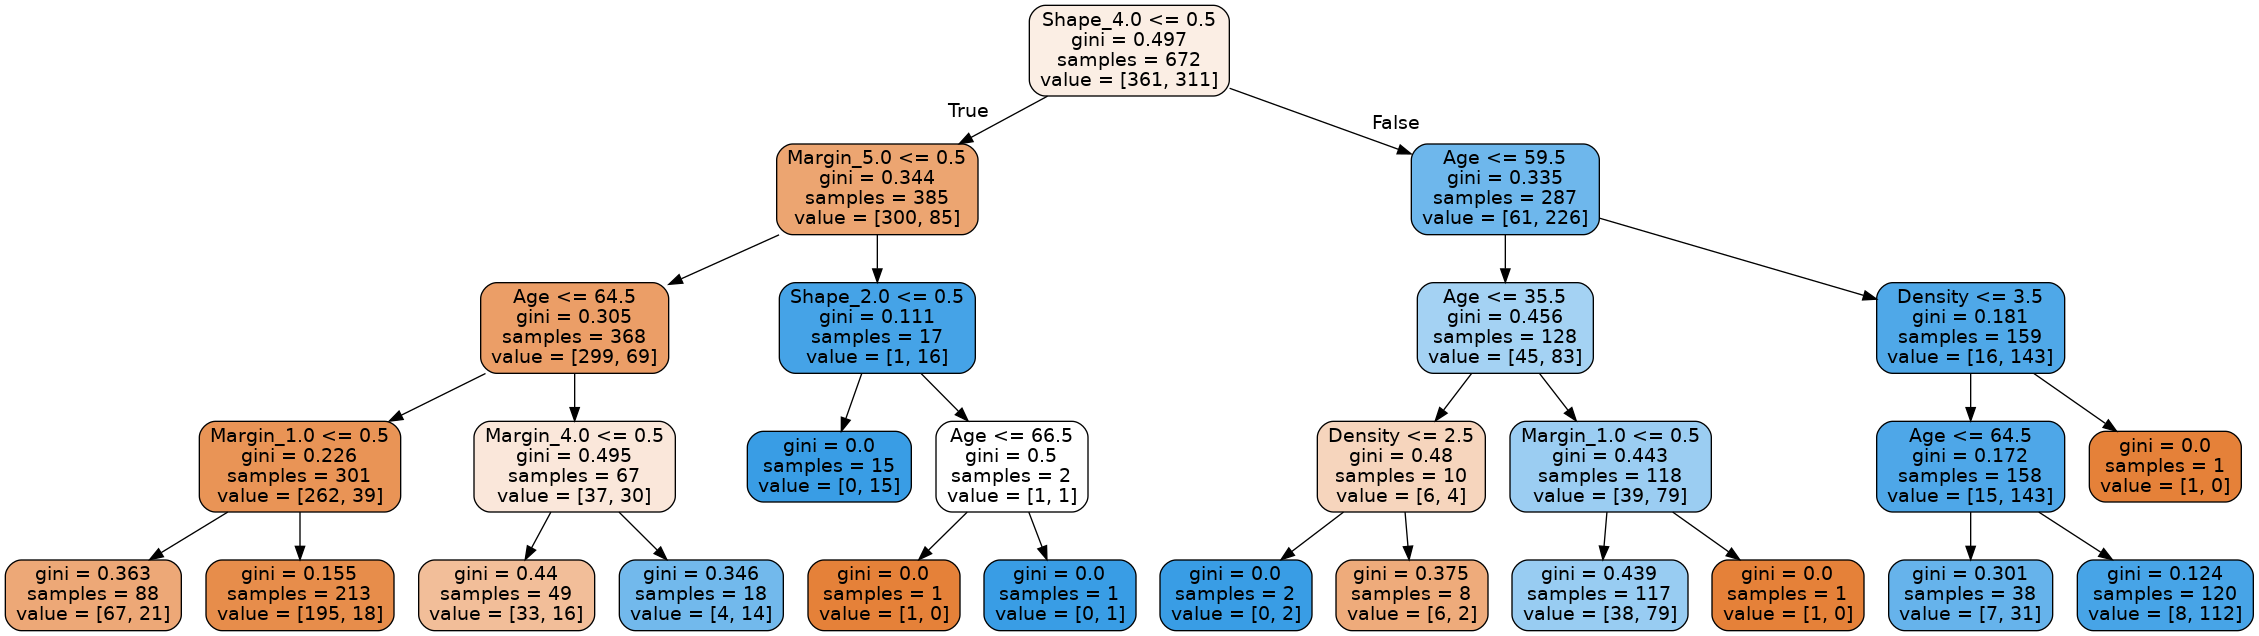

In [124]:
# Visualise the resulting decision tree
from graphviz import Source
feature_names= list(data_one_hot.iloc[:, 1:].columns)

dot_data = StringIO() 
tree.export_graphviz(final_dtree, out_file= dot_data, feature_names=feature_names, filled=True,rounded=True)
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

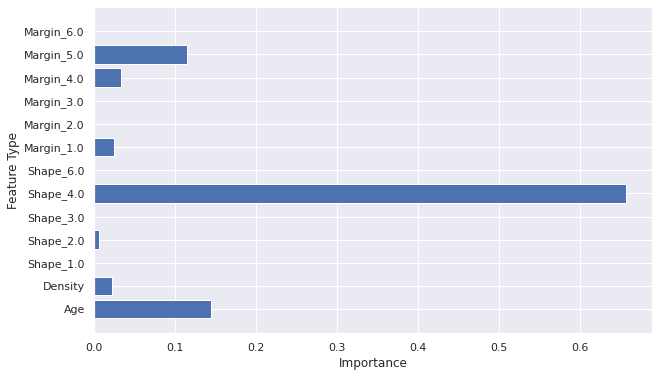

In [125]:
#plot feature importances 
feature_imps= final_dtree.feature_importances_
plt.figure(figsize= (10,6))
plt.barh(feature_names, feature_imps)
plt.xlabel('Importance')
plt.ylabel('Feature Type')
plt.show()

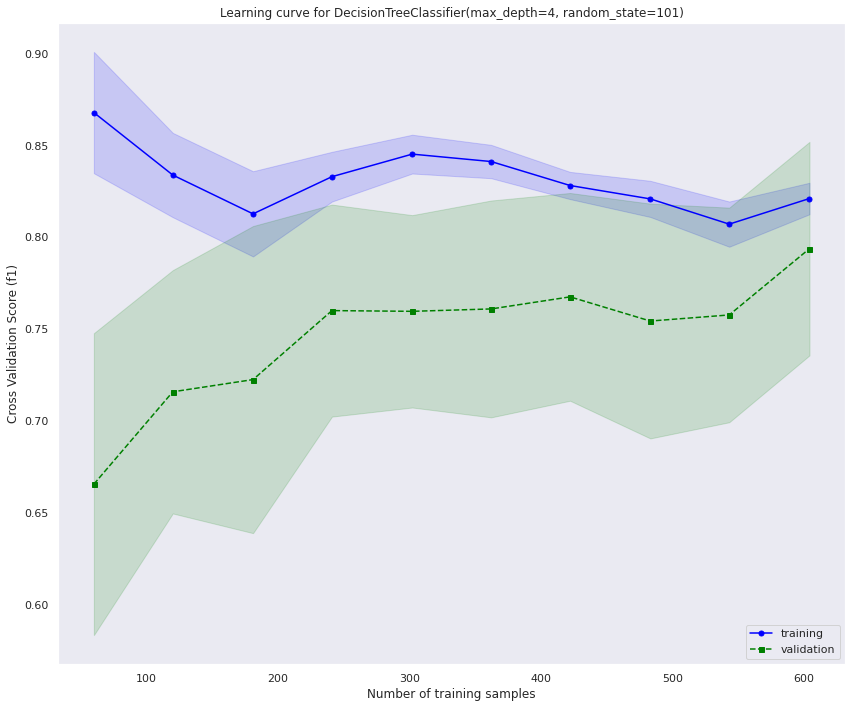

In [126]:
#plot the final learning curve
#to see bias variance trade off 
train_sizes=np.linspace(0.1, 1.0, 10)
plot_learning_curve(final_dtree, X_train, y_train, train_sizes, cv)

In [127]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#function to plot auc curve
def plot_roc(models, model_labels): 
    
    colors = ['blue', 'orange', 'purple', 'green']
    linestyles = [':', '--', '-.', '-']
    for model, label, colour, line \
        in zip(models, model_labels, colors, linestyles):
        y_pred = model.fit(X_train, 
                         y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test, 
                                         y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, 
                 color=colour, 
                 linestyle=line, 
                 label='%s (auc = %0.2f)' % (label, roc_auc))

    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()

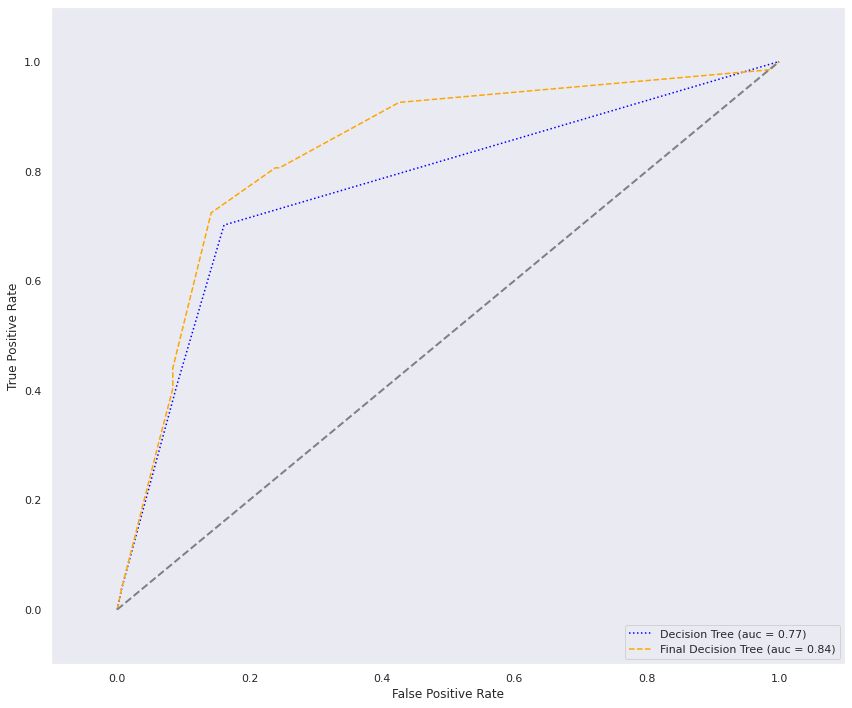

In [128]:
#plot roc 
model_labels = ['Decision Tree', 'Final Decision Tree']
models = [dtree, final_dtree]
plot_roc(models, model_labels)

# 2. AdaBoost Classifier

Details here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

N.B. Please see report for psuedocode

In [129]:
#import and define model (1 level decision tree is default base estimator)
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=10, 
                         learning_rate=0.1,
                         random_state=101) 

In [130]:
#check out model parameters 
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.1,
 'n_estimators': 10,
 'random_state': 101}

### Performance Metrics

In [131]:
#fit the model and check out prediction accuracy on training and test sets
from sklearn.metrics import f1_score

ada.fit(X_train, y_train)
ada_predict_train = ada.predict(X_train)
ada_predict_test = ada.predict(X_test)

ada_train = f1_score(y_train, ada_predict_train) 
ada_test = f1_score(y_test, ada_predict_test) 
print('AdaBoost train/test f1: %.3f/%.3f'
      % (ada_train, ada_test))

AdaBoost train/test f1: 0.802/0.753


In [132]:
#k fold cross validation with k=10 to get a more robust measure of accuracy 
from sklearn.model_selection import RepeatedStratifiedKFold

ada_scores = cross_val_score(ada, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1, error_score='raise')

print('Kfold cross val f1: %.3f (%.3f)' % (np.mean(ada_scores), np.std(ada_scores)))

Kfold cross val f1: 0.778 (0.054)


In [133]:
#confusion matrix and classification report for unbalanced data 
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,ada_predict_test))
print(classification_report(y_test, ada_predict_test))

[[125  30]
 [ 35  99]]
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79       155
         1.0       0.77      0.74      0.75       134

    accuracy                           0.78       289
   macro avg       0.77      0.77      0.77       289
weighted avg       0.77      0.78      0.77       289



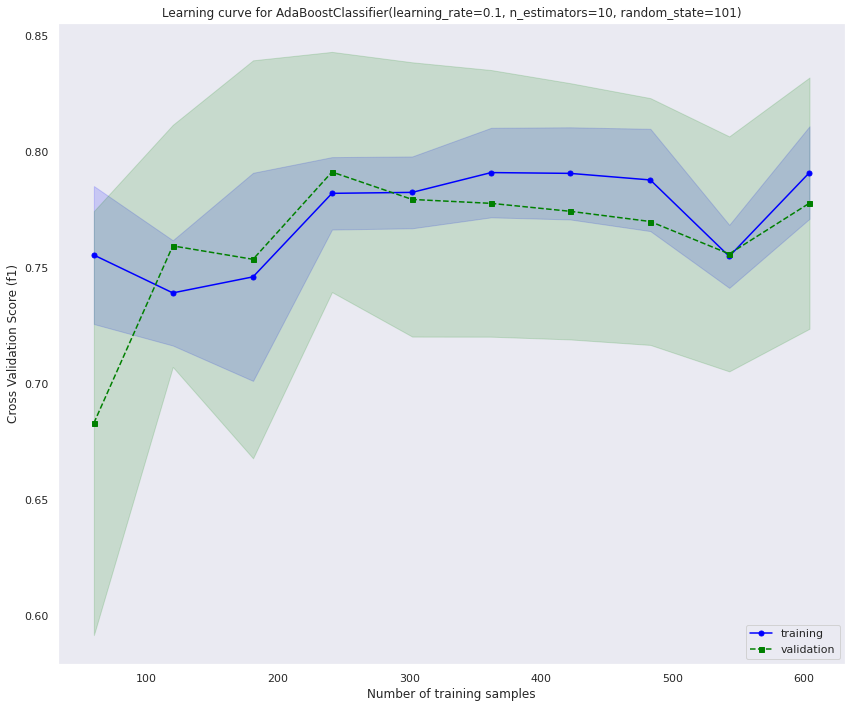

In [134]:
#plot learning curve to see bias-variance trade off 
train_sizes_ada=np.linspace(0.1, 1.0, 10)
plot_learning_curve(ada, X_train, y_train, train_sizes_ada, cv)

### Hyperparameter Tuning

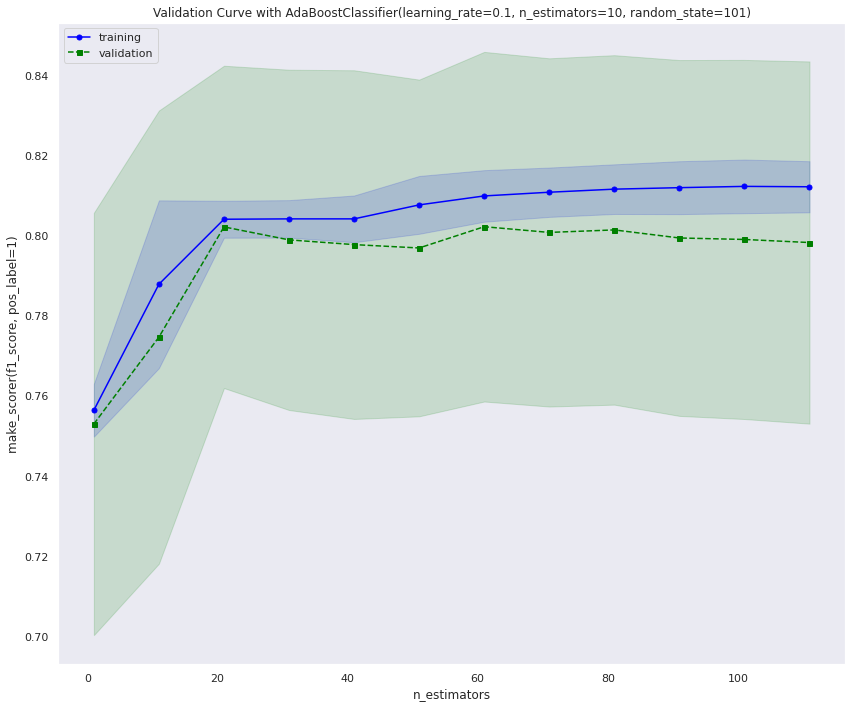

In [135]:
#validation curve to explore number of base estimators
nest_param_range = np.arange(1, 120, 10)
plot_val_curve(ada, X_train, y_train, "n_estimators", cv, nest_param_range, scorer)

In [136]:
#grid search for best parameters
param_dict_ada = {'n_estimators':[20, 30, 40, 50, 60, 70, 80, 100],
                  'learning_rate':[0.1]}

ada_gs = GridSearchCV(AdaBoostClassifier(random_state=101), param_dict_ada, scoring= scorer, cv=cv) 

ada_gs.fit(X_train, y_train) 

print(round(ada_gs.best_score_, 3)) 
print(ada_gs.best_params_)

0.802
{'learning_rate': 0.1, 'n_estimators': 20}


In [137]:
#use best model and fit as final model to our training data 
final_ada = ada_gs.best_estimator_
final_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=20, random_state=101)

In [138]:
#cross validation for more robust f1 estimate 
final_ada_scores = cross_val_score(final_ada, X_train, y_train, scoring= scorer, cv=cv)
print('Original CV f1: %.3f +/- %.3f' % (np.mean(ada_scores), np.std(ada_scores)))
print('Final CV f1: %.3f +/- %.3f' % (np.mean(final_ada_scores), np.std(final_ada_scores)))

Original CV f1: 0.778 +/- 0.054
Final CV f1: 0.802 +/- 0.040


In [139]:
#train/test
final_ada_predict_train= final_ada.predict(X_train)
final_ada_predict_test = final_ada.predict(X_test) 

final_ada_train = f1_score(y_train, final_ada_predict_train) 
final_ada_test = f1_score(y_test, final_ada_predict_test) 
print('Final AdaBoost train/test f1: %.3f/%.3f'
      % (final_ada_train, final_ada_test))

Final AdaBoost train/test f1: 0.804/0.753


In [140]:
#Check out other peformance metrics 
print(confusion_matrix(y_test, final_ada_predict_test))
print(classification_report(y_test, final_ada_predict_test))

[[125  30]
 [ 35  99]]
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79       155
         1.0       0.77      0.74      0.75       134

    accuracy                           0.78       289
   macro avg       0.77      0.77      0.77       289
weighted avg       0.77      0.78      0.77       289



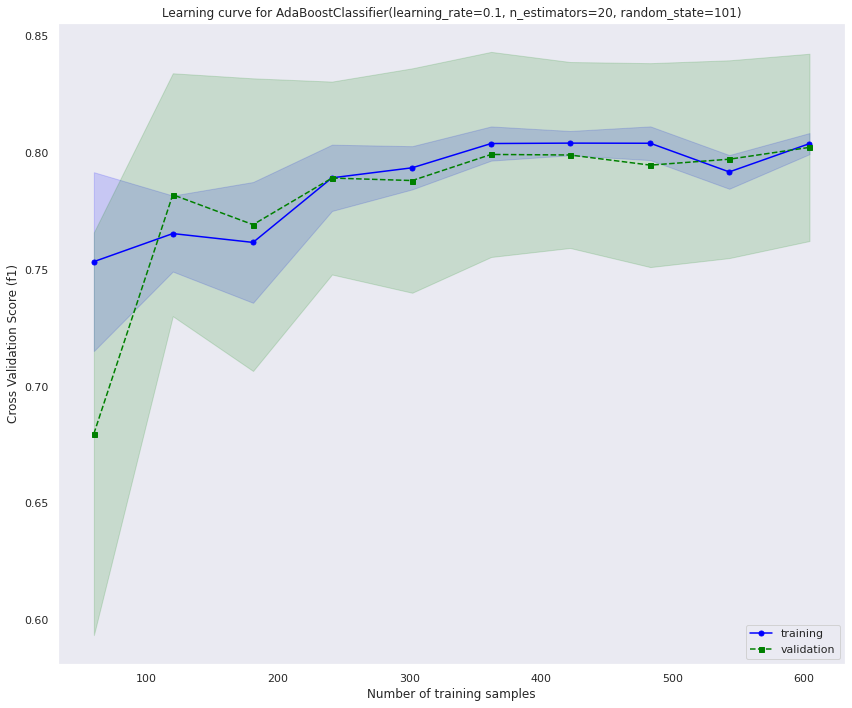

In [141]:
#plot learning curve to see bias-variance trade off 
train_sizes_ada=np.linspace(0.1, 1.0, 10)
plot_learning_curve(final_ada, X_train, y_train, train_sizes_ada, cv)

Adaboost is not outperforming single best dtree, i will try this as a base to see if I can get a better performance

In [142]:
#try final_dtree as base estimator 
final_ada2 = AdaBoostClassifier(base_estimator= final_dtree, n_estimators=6, 
                         learning_rate=0.1,
                         random_state=101) 
final_ada2.fit(X_train, y_train)
final_ada2_predict_train = final_ada2.predict(X_train)
final_ada2_predict_test = final_ada2.predict(X_test)

final_ada2_train = f1_score(y_train, final_ada2_predict_train) 
final_ada2_test = f1_score(y_test, final_ada2_predict_test) 
print('AdaBoost train/test f1: %.3f/%.3f'
      % (final_ada2_train, final_ada2_test))

AdaBoost train/test f1: 0.833/0.780


In [143]:
#cross validation for more robust f1 estimate 
final_ada2_scores = cross_val_score(final_ada2, X_train, y_train, scoring= scorer, cv=cv)
print('Final 1 CV f1: %.3f +/- %.3f' % (np.mean(final_ada_scores), np.std(final_ada_scores)))
print('Final 2 CV f1: %.3f +/- %.3f' % (np.mean(final_ada2_scores), np.std(final_ada2_scores)))

Final 1 CV f1: 0.802 +/- 0.040
Final 2 CV f1: 0.787 +/- 0.057


In [144]:
#Check out other peformance metrics 
print(confusion_matrix(y_test, final_ada2_predict_test))
print(classification_report(y_test, final_ada2_predict_test))

[[128  27]
 [ 31 103]]
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       155
         1.0       0.79      0.77      0.78       134

    accuracy                           0.80       289
   macro avg       0.80      0.80      0.80       289
weighted avg       0.80      0.80      0.80       289



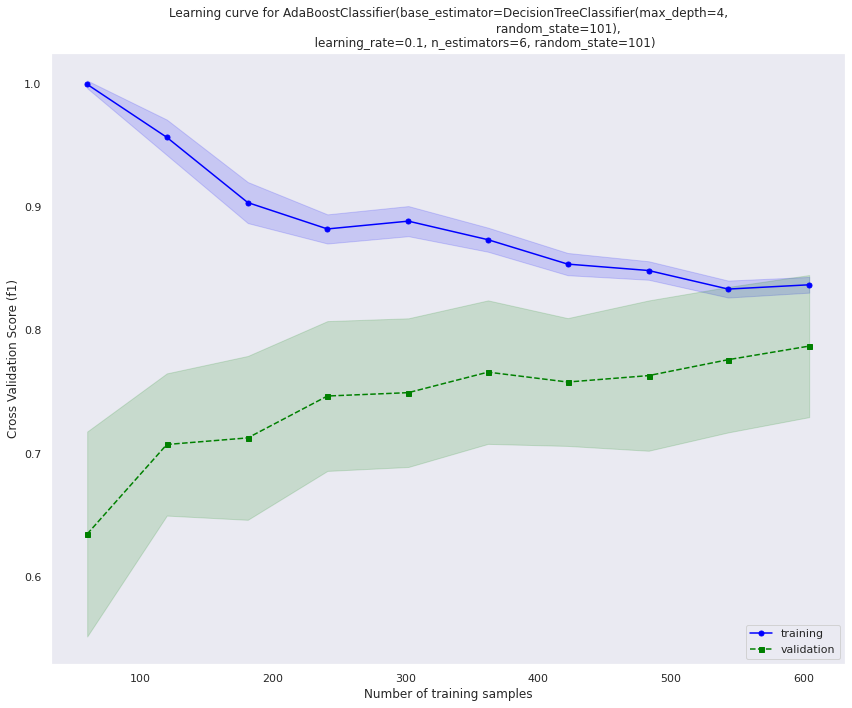

In [145]:
#plot learning curve to see bias-variance trade off 
train_sizes_ada=np.linspace(0.1, 1.0, 10)
plot_learning_curve(final_ada2, X_train, y_train, train_sizes_ada, cv)

# Summary of Results

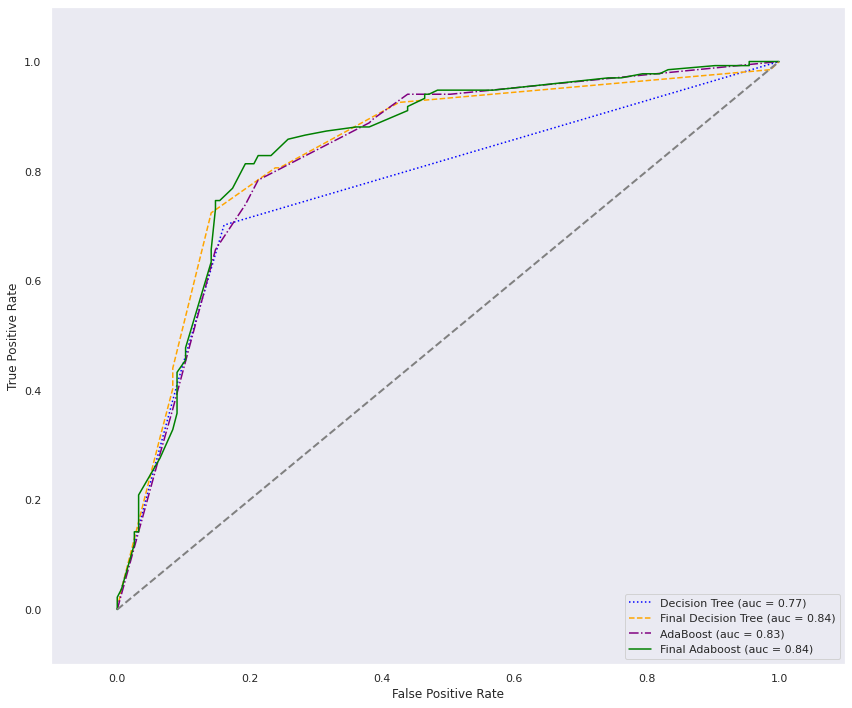

In [146]:
#plot ric curve for all models 
model_labels2 = ['Decision Tree', 'Final Decision Tree', 'AdaBoost', 'Final Adaboost']
models2 = [dtree, final_dtree, ada, final_ada2]
plot_roc(models2, model_labels2)

In [147]:
#imports 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

#calculate averages across malignant and benign labels 
#f1
ada_f1= round(f1_score(y_test, final_ada_predict_test), 3)
ada_f1_1= round(f1_score(y_test, final_ada2_predict_test, pos_label=1), 3)
ada_f1_0= round(f1_score(y_test, final_ada2_predict_test, pos_label=0), 3)
ada_f1_w= round(f1_score(y_test, final_ada2_predict_test, average= "weighted"), 3)

dtree_f1_1= round(f1_score(y_test, final_dtree_predict_test, pos_label=1), 3)
dtree_f1_0= round(f1_score(y_test, final_dtree_predict_test, pos_label=0), 3)
dtree_f1_w= round(f1_score(y_test, final_dtree_predict_test, average= "weighted"), 3)

#accuracy 
ada_a= round(accuracy_score(y_test, final_ada2_predict_test), 3)
dtree_a= round(accuracy_score(y_test, final_dtree_predict_test), 3)

#precision
ada_p_1= round(precision_score(y_test, final_ada2_predict_test, pos_label=1), 3)
ada_p_0= round(precision_score(y_test, final_ada2_predict_test, pos_label=0), 3)
ada_p_w= round(precision_score(y_test, final_ada2_predict_test, average= "weighted"), 3)

dtree_p_1= round(precision_score(y_test, final_dtree_predict_test, pos_label=1), 3)
dtree_p_0= round(precision_score(y_test, final_dtree_predict_test, pos_label=0), 3)
dtree_p_w= round(precision_score(y_test, final_dtree_predict_test, average= "weighted"), 3)

#recall 
ada_r_1= round(recall_score(y_test, final_ada2_predict_test, pos_label=1), 3)
ada_r_0= round(recall_score(y_test, final_ada2_predict_test, pos_label=0), 3)
ada_r_w= round(recall_score(y_test, final_ada2_predict_test, average= "weighted"), 3)

dtree_r_1= round(recall_score(y_test, final_dtree_predict_test, pos_label=1), 3)
dtree_r_0= round(recall_score(y_test, final_dtree_predict_test, pos_label=0), 3)
dtree_r_w= round(recall_score(y_test, final_dtree_predict_test, average= "weighted"), 3)

In [148]:
#make a table of results of final best models for DT and ABC 
from tabulate import tabulate
table_f1= [['Model', 'Metric', 'Malignant', 'Benign', 'Weighted'],
           ['Dtree', 'f1', dtree_f1_1, dtree_f1_0, dtree_f1_w], 
           ['Ada', 'f1', ada_f1_1, ada_f1_0, ada_f1_w],
           ['Dtree', 'Precision', dtree_p_1, dtree_p_0, dtree_p_w],
           ['Ada', 'Precision', ada_p_1, ada_p_0, ada_p_w],
           ['Dtree', 'Recall', dtree_r_1, dtree_r_0, dtree_r_w],
           ['Ada', 'Recall', ada_r_1, ada_r_0, ada_r_w]]

print(tabulate(table_f1, headers= "firstrow", tablefmt= "fancy_grid"))
print(f"Accuracy: \n Dtree  {dtree_a} \n Ada  {ada_a}")

╒═════════╤═══════════╤═════════════╤══════════╤════════════╕
│ Model   │ Metric    │   Malignant │   Benign │   Weighted │
╞═════════╪═══════════╪═════════════╪══════════╪════════════╡
│ Dtree   │ f1        │       0.767 │    0.818 │      0.795 │
├─────────┼───────────┼─────────────┼──────────┼────────────┤
│ Ada     │ f1        │       0.78  │    0.815 │      0.799 │
├─────────┼───────────┼─────────────┼──────────┼────────────┤
│ Dtree   │ Precision │       0.815 │    0.782 │      0.798 │
├─────────┼───────────┼─────────────┼──────────┼────────────┤
│ Ada     │ Precision │       0.792 │    0.805 │      0.799 │
├─────────┼───────────┼─────────────┼──────────┼────────────┤
│ Dtree   │ Recall    │       0.724 │    0.858 │      0.796 │
├─────────┼───────────┼─────────────┼──────────┼────────────┤
│ Ada     │ Recall    │       0.769 │    0.826 │      0.799 │
╘═════════╧═══════════╧═════════════╧══════════╧════════════╛
Accuracy: 
 Dtree  0.796 
 Ada  0.799


# END